In [1]:
from pioneerml.zenml import utils as zenml_utils

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default


In [2]:
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml.pipelines.training import pion_stop_optuna_pipeline
from pioneerml.optuna import OptunaStudyManager


# Set up Optuna storage
optuna_manager = OptunaStudyManager(
    project_root=PROJECT_ROOT,
    study_name="pion_stop",
)
optuna_storage = optuna_manager.resolve_storage()
print(f"Using Optuna storage: {optuna_storage}")


Using Optuna storage: sqlite:////home/jack/python_projects/pioneerML/.optuna/pion_stop.db


In [3]:
# Configure the pipeline
# Use absolute path based on project root
# All models use the same source data: mainTimeGroups_*.npy
hits_pattern = str(Path(PROJECT_ROOT) / "data" / "hits_batch_*.npy")
info_pattern = str(Path(PROJECT_ROOT) / "data" / "group_info_batch_*.npy")

run = pion_stop_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params={
        "hits_pattern": hits_pattern,
        "info_pattern": info_pattern,
        "max_files": 20,
        "limit_groups": 1_000_000,
        "min_hits": 2,
        "batch_size": 128,
        "num_workers": None,
        "val_split": 0.15,
        "seed": 42,
    },
    run_hparam_search_params={
        'n_trials': 1,               # Optuna trials for the search step
        'max_epochs': 1,             # epochs per trial during search
        'limit_train_batches': 0.8,   # fraction/int of train batches per trial
        'limit_val_batches': 1.0,     # fraction/int of val batches per trial
        'storage': optuna_storage,
        'study_name': 'pion_stop',
    },
    train_best_model_params={
        'max_epochs': 2,             # final training epochs cap
        'early_stopping': True,        # enable early stopping
        'early_stopping_patience': 2, # patience for early stopping
        'early_stopping_monitor': 'val_loss',
        'early_stopping_mode': 'min',
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: pion_stop_optuna_pipeline.
Caching is disabled by default for pion_stop_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_pion_stop_datamodule has started.


[build_pion_stop_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_pion_stop_datamodule] Starting to load data from: hits=/home/jack/python_projects/pioneerML/data/hits_batch_*.npy, info=/home/jack/python_projects/pioneerML/data/group_info_batch_*.npy
[build_pion_stop_datamodule] Limiting to 11 files (from 11 total files found, max_files=20)
[build_pion_stop_datamodule] Limiting to 11 files (from 11 total files found, max_files=20)
[build_pion_stop_datamodule] Loaded 109817 groups from 11 file pairs
[build_pion_stop_datamodule] Loaded 109817 groups. Building datamodule...
[build_pion_stop_datamodule] Calling setup(stage='fit')...
[build_pion_stop_datamodule] Setup complete. Train: 93345, Val: 16472


Step build_pion_stop_datamodule has finished in 19.490s.
Step run_pion_stop_hparam_search has started.


[run_pion_stop_hparam_search] Using GPU: NVIDIA GeForce RTX 5070
[run_pion_stop_hparam_search] CUDA devices: 1
[run_pion_stop_hparam_search] Enabled Tensor Core optimization (medium precision)
[run_pion_stop_hparam_search] Dataset sizes - Train: 93345, Val: 16472
[run_pion_stop_hparam_search] Starting Optuna search with 1 trials, 1 epochs per trial...
[I 2026-01-02 08:04:05,866] Using an existing study with name 'pion_stop' instead of creating a new one.
[run_pion_stop_hparam_search] Starting Optuna study (storage=sqlite:////home/jack/python_projects/pioneerML/.optuna/pion_stop.db, name=pion_stop)...


  0%|          | 0/1 [00:00<?, ?it/s]

[run_pion_stop_hparam_search] Trial 1/1 (cumulative 4/4) starting...
[run_pion_stop_hparam_search] Trial 1 params: batch_size=64, hidden=192 (from 192), heads=4, layers=4, dropout=0.0776, lr=0.003421, weight_decay=0.000032
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_pion_stop_hparam_search] Trial 1 training 1 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor │  2.1 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 78                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


[run_pion_stop_hparam_search] Trial 1 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_pion_stop_hparam_search] Trial 1 completed with score: 0.349022
[run_pion_stop_hparam_search] Optuna search complete! Best score: 0.592168
[run_pion_stop_hparam_search] Best params: {'batch_size': 16, 'hidden': 192, 'heads': 4, 'layers': 4, 'dropout': 0.08776396573038472, 'lr': 0.0009808073349973085, 'weight_decay': 6.835176947900822e-05}


[I 2026-01-02 08:05:25,411] Trial 3 finished with value: 0.3490224791964311 and parameters: {'batch_size': 64, 'hidden': 192, 'heads': 4, 'layers': 4, 'dropout': 0.0776272937480498, 'lr': 0.0034211433380723446, 'weight_decay': 3.225535547912906e-05}. Best is trial 2 with value: 0.5921682669451849.
Step run_pion_stop_hparam_search has finished in 1m21s.
Step train_best_pion_stop_regressor has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor │  2.1 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss           │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 78                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Step train_best_pion_stop_regressor has finished in 8m29s.
Step collect_pion_stop_predictions has started.
Step collect_pion_stop_predictions has finished in 2m11s.
Pipeline run has finished in 12m24s.
Run name: pion_stop_optuna_pipeline-2026_01_02-13_03_42_488211
Run status: completed


In [4]:
# Load artifacts from the pipeline run
trained_module = load_step_output(run, "train_best_pion_stop_regressor")
datamodule = load_step_output(run, "build_pion_stop_datamodule")
predictions = load_step_output(run, "collect_pion_stop_predictions", index=0)
targets = load_step_output(run, "collect_pion_stop_predictions", index=1)
best_params = load_step_output(run, "run_pion_stop_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")
print("Best params from Optuna:", best_params)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))



Loaded module on cpu; validation samples: 16472
Best params from Optuna: {'batch_size': 16, 'hidden': 192, 'heads': 4, 'layers': 4, 'dropout': 0.08776396573038472, 'lr': 0.0009808073349973085, 'weight_decay': 6.835176947900822e-05, 'best_score': 0.5921682669451849, 'n_trials': 4} {'batch_size': 16, 'hidden': 192, 'heads': 4, 'layers': 4, 'dropout': 0.08776396573038472, 'lr': 0.0009808073349973085, 'weight_decay': 6.835176947900822e-05, 'best_score': 0.5921682669451849, 'n_trials': 4}
Epochs actually run: 3 3


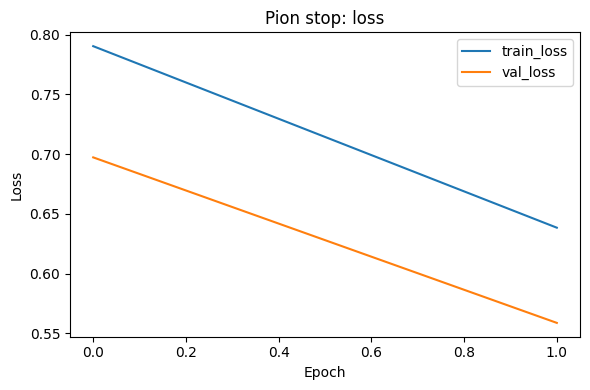

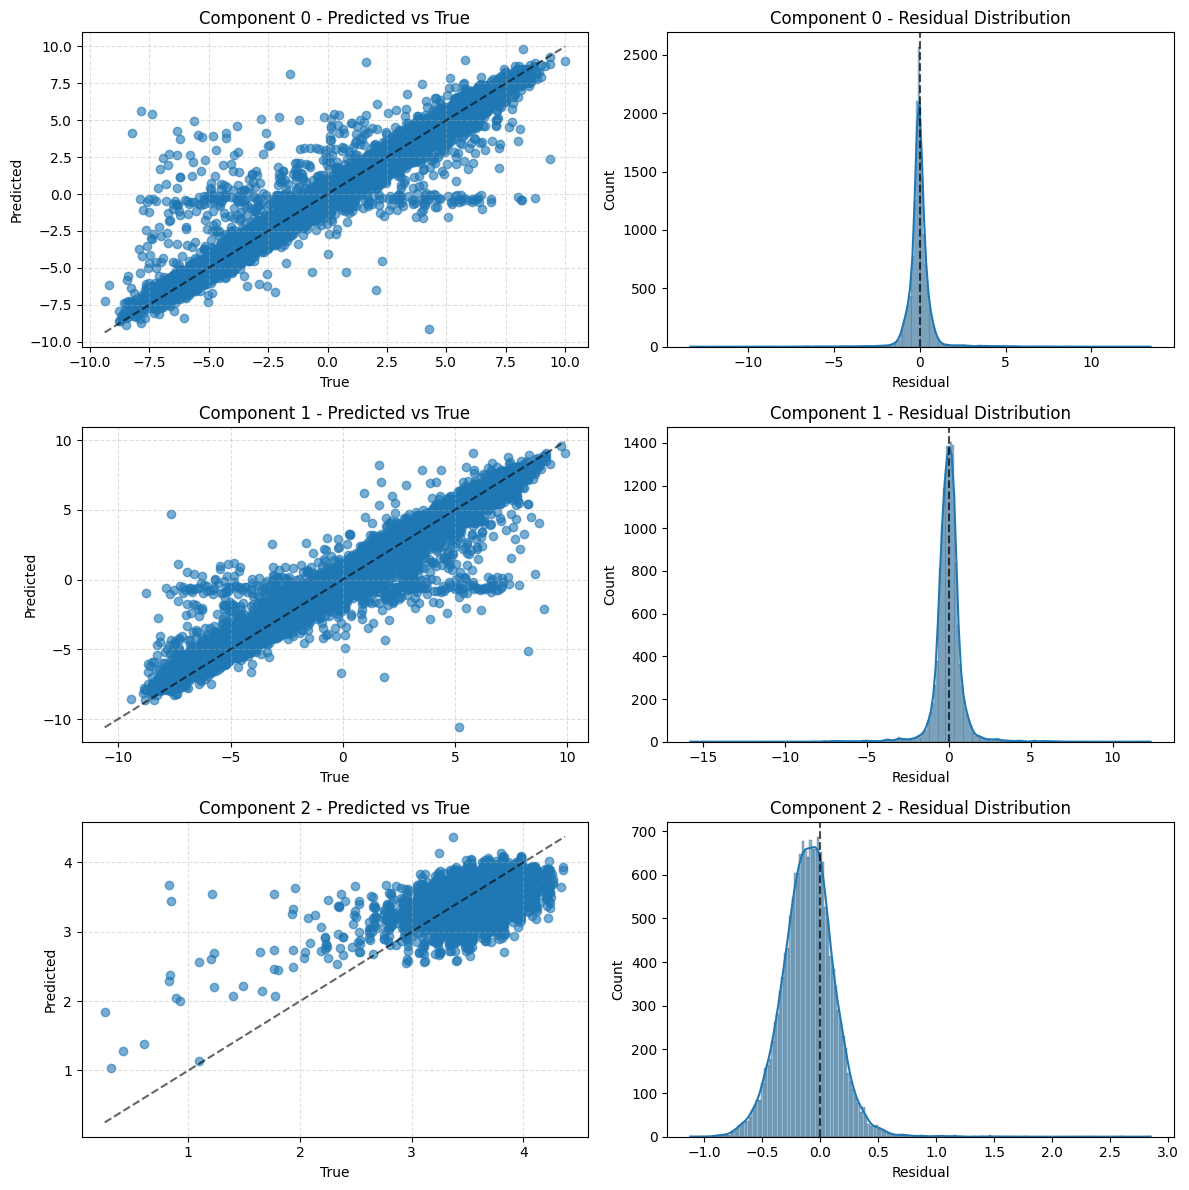

In [5]:
from pioneerml.evaluation.plots import plot_loss_curves, plot_regression_diagnostics

# Loss curves
plot_loss_curves(trained_module, title="Pion stop: loss", show=True)

# Regression diagnostics
plot_regression_diagnostics(predictions=predictions, targets=targets, show=True)


## Save the Trained Model

Save the trained model and metadata for later use.


In [6]:
from pioneerml.metadata import TrainingMetadata, save_model_and_metadata, timestamp_now

# Build metadata and save model + metadata together
save_ts = timestamp_now()

meta = TrainingMetadata(
    model_type="PionStopRegressor",
    timestamp=save_ts,
    run_name=run.name if 'run' in locals() else None,
    best_hyperparameters=best_params,
    best_score=best_params.get('best_score') if isinstance(best_params, dict) else None,
    n_trials=best_params.get('n_trials') if isinstance(best_params, dict) else None,
    training_config=getattr(trained_module, 'training_config', {}),
    epochs_run=getattr(trained_module, 'final_epochs_run', None),
    dataset_info={
        'train_size': len(datamodule.train_dataset) if datamodule.train_dataset else 0,
        'val_size': len(datamodule.val_dataset) if datamodule.val_dataset else 0,
        'task': 'regression',
    },
    model_architecture={
        'hidden': best_params.get('hidden') if isinstance(best_params, dict) else None,
        'heads': best_params.get('heads') if isinstance(best_params, dict) else None,
        'layers': best_params.get('layers') if isinstance(best_params, dict) else None,
        'dropout': best_params.get('dropout') if isinstance(best_params, dict) else None,
    },
    # Store link to Optuna DB instead of full history
    optuna_storage=optuna_storage,
    optuna_study_name=optuna_manager.study_name,
)

paths = save_model_and_metadata(
    model=trained_module.model,
    metadata=meta,
    state_dict_only=True,
)

print("Saved artifacts:")
for k, v in paths.items():
    print(f"  {k}: {v}")


Saved artifacts:
  dir: /home/jack/python_projects/pioneerML/trained_models/pionstopregressor
  state_dict: /home/jack/python_projects/pioneerML/trained_models/pionstopregressor/pionstopregressor_20260102_131611_pion_stop_optuna_pipeline-2026_01_02-13_03_42_488211_state_dict.pt
  metadata: /home/jack/python_projects/pioneerML/trained_models/pionstopregressor/pionstopregressor_20260102_131611_pion_stop_optuna_pipeline-2026_01_02-13_03_42_488211_metadata.json
  full_checkpoint: /home/jack/python_projects/pioneerML/trained_models/pionstopregressor/pionstopregressor_20260102_131611_pion_stop_optuna_pipeline-2026_01_02-13_03_42_488211_checkpoint.pt
